<center><h1>BMIF804</h1>
    <h2>Assignment 3</h2>  
    <h3>By: Hannah Driver (10090525)</h3>
    <h4>https://github.com/hannahdriver/BMIF804_Assignment3</h4></center>

<b>This program reads in a prostate ultrasound image, a segmented prostate image, and a csv file, and then adjusts the image metadata based on the inputs in the CSV file. The prostate ultrasound image is enhanced using median and contrast filtering, and the prostate is segmented from the image using a confidence connected algorithm. Finally, the area, volume, and mean and standard deviation of pixel intensities are calculated for the segmented prostate.</b>

In [57]:
# import libraries
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%config Completer.use_jedi = False

<h2>Data Preparation</h2>

In [58]:
def readImage(imageName):
    """
    Read in file to create image object
    :param imageName: name of the file to read in
    :return: image object
    """
    image = sitk.ReadImage(imageName)
    return image

In [59]:
#read in images and name them

img = readImage('new_prostate.tif')
img_name = "Prostate Image"
#img = sitk.Cast(img, sitk.sitkFloat64)

img2 = readImage('new_segemnt.tif')
img2_name = "Segment Image"

In [60]:
#Set up the 3D Slicer external viewr
external_viewer = sitk.ImageViewer()
slicer_app_location = "C:\\Program Files\\Slicer 4.8.1\\Slicer.exe"
external_viewer.SetApplication(slicer_app_location)

<h2>Part 1</h2>

<h5>Part 1a</h5>

Prostate image as viewed in 3D Slicer:

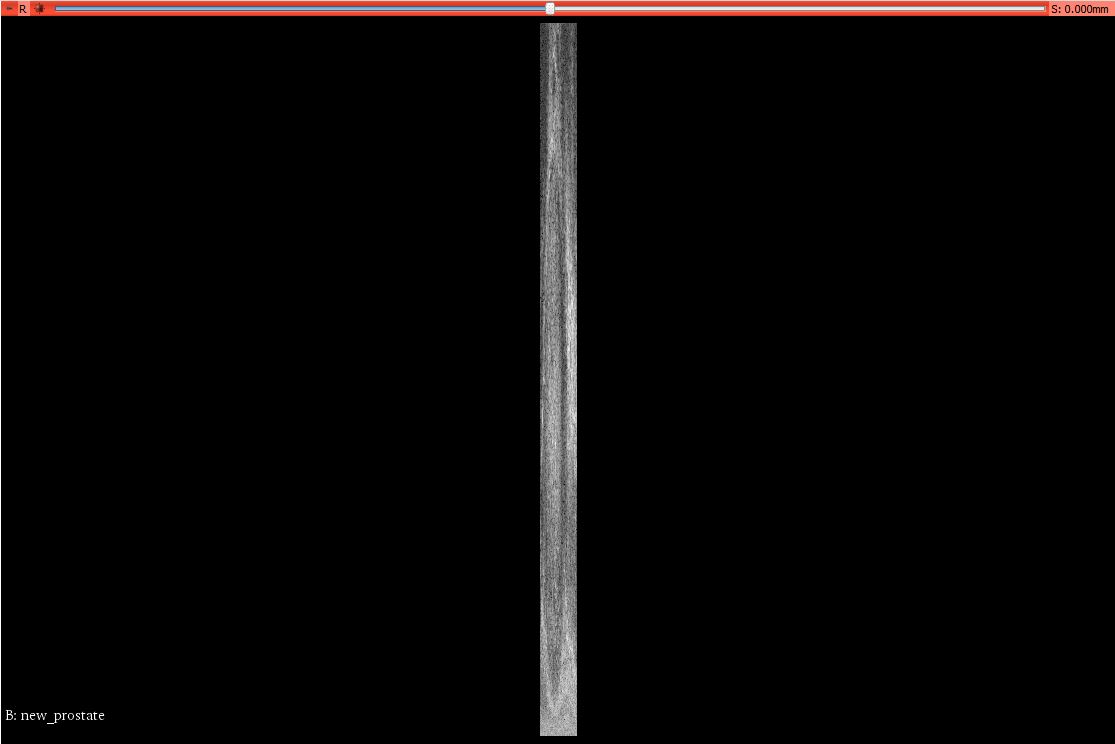

<h5>Part 1b</h5>

In [61]:
#read in metadata

df = pd.read_csv('meta_data.csv')

print(df)

          data_name  axial (mm)  lateral (mm)  grade     organ    modality
0  PCC-0312_LAL_GS7          28         46.08      7  prostate  ultrasound


<h5>Part 1c</h5>

In [62]:
def changeImageSpacing(image, axialExtent, lateralExtent):
    """
    Update the spacing for an image based on the desired axial and lateral extents and sizes
    :param image: image object 
    :param axialExtent: desired axial extent of an image in mm
    :param lateralExtent: desired lateral extent of an image in mm
    :return: image object with new spacing
    """
    axial_size = image.GetSize()[1]
    lateral_size = image.GetSize()[0]
    
    axial_spacing = axialExtent / axial_size
    lateral_spacing = lateralExtent / lateral_size
    
    print("The axial spacing is: {:.4f} mm".format(axial_spacing))
    print("The lateral spacing is: {} mm".format(lateral_spacing))
    
    image.SetSpacing((lateral_spacing,axial_spacing))
    
    return image

In [63]:
#Get extents of axial and lateral dimensions
axial_extent = float(df['axial (mm)'])
lateral_extent = float(df['lateral (mm)'])

#Use physical extents and sizes of images to calculate image spacing
img_updated = changeImageSpacing(img, axial_extent, lateral_extent)

#Write new image
sitk.WriteImage(img_updated,"prostate_ultrasound.nrrd")

The axial spacing is: 0.0028 mm
The lateral spacing is: 0.09 mm


The ratio of the axial to lateral spacing reveals that the lateral length of each pixel is more than a magnitude greater than the axial length of each pixel; so the pixels are nonisotropic.

<h5>Part 1d</h5>

In [64]:
img_p = readImage('prostate_ultrasound.nrrd')
img_p_name = "Prostate Ultrasound"

#View updated prostate ultrasound in 3D Slicer
external_viewer.Execute(img_p)

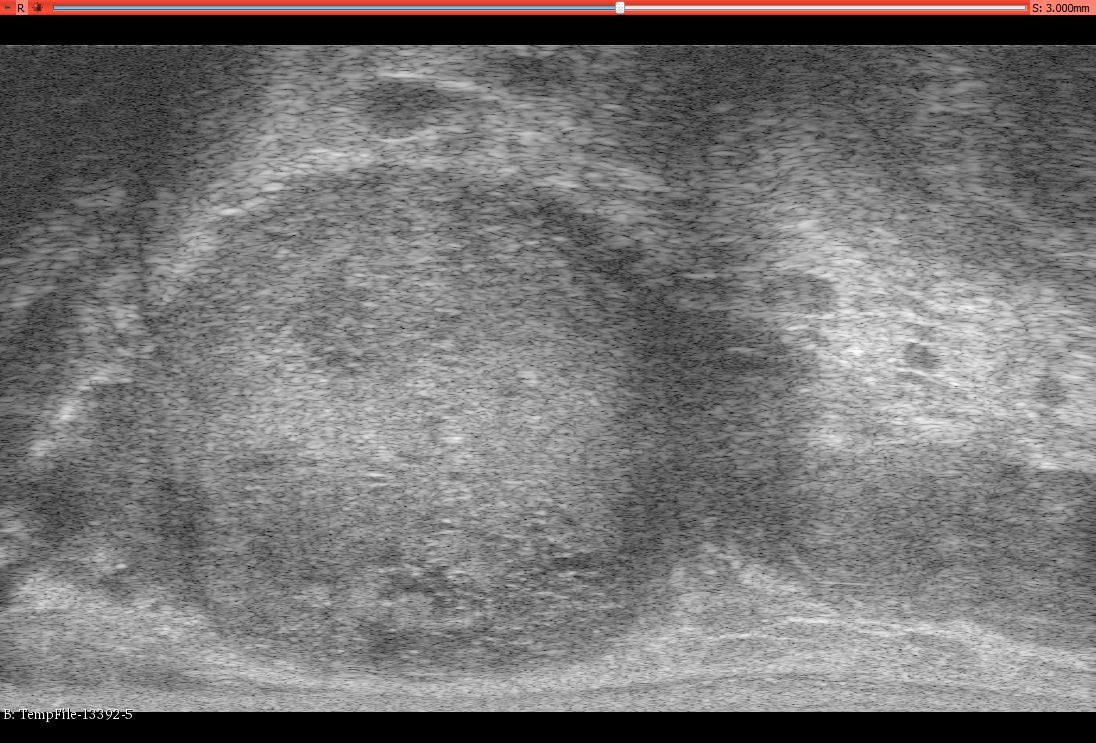

Although this is the same image that was visualized in part 1a, it appears much more sensical to the human eye. This is because the spacing of the image has been changed to match what the proportions of the organ look like in real life. Thus, we end up with a wider image, rather than a skinny, long one.

<h5>Part 1e</h5>

Segment image as viewed in 3D Slicer

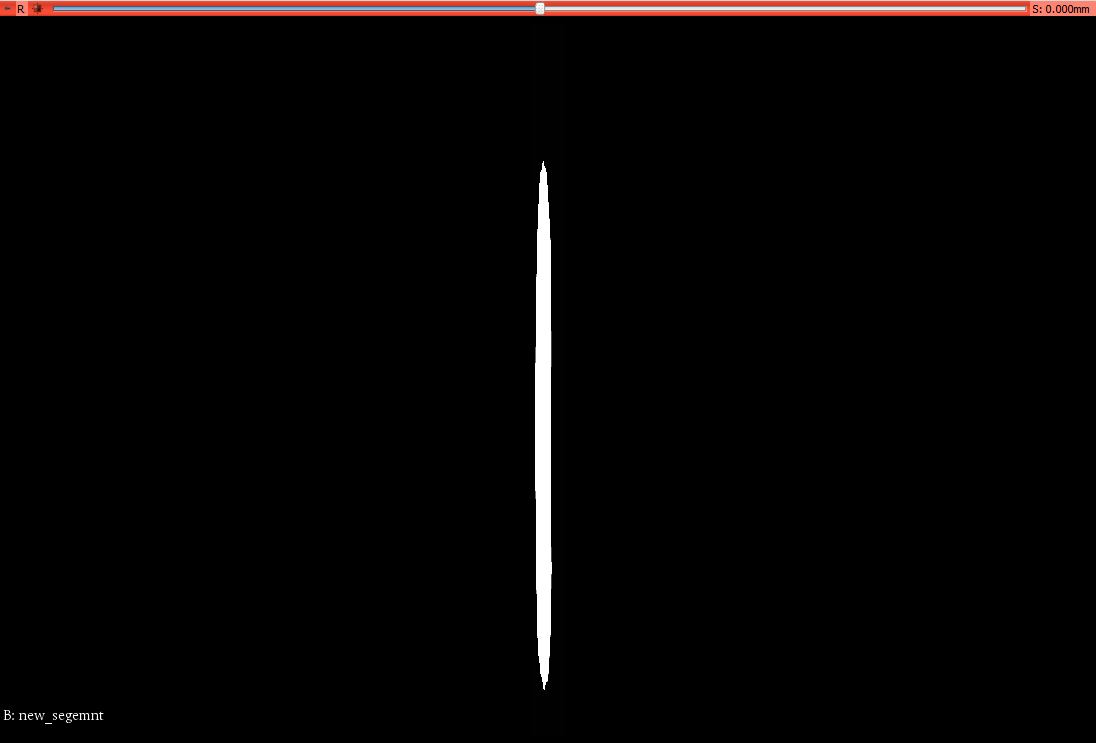

In [65]:
#Use physical extents and sizes of images to calculate image spacing
img2_updated = changeImageSpacing(img2, axial_extent, lateral_extent)

#Write new image
sitk.WriteImage(img2,"prostate_segment.nrrd")

#Import "nrrd" image
img_s = readImage('prostate_segment.nrrd')
img_s_name = "Prostate Segment"

#View updated prostate segment in 3D Slicer
external_viewer.Execute(img_s)

The axial spacing is: 0.0028 mm
The lateral spacing is: 0.09 mm


Segment image with updated spacing, as viewed in 3D Slicer

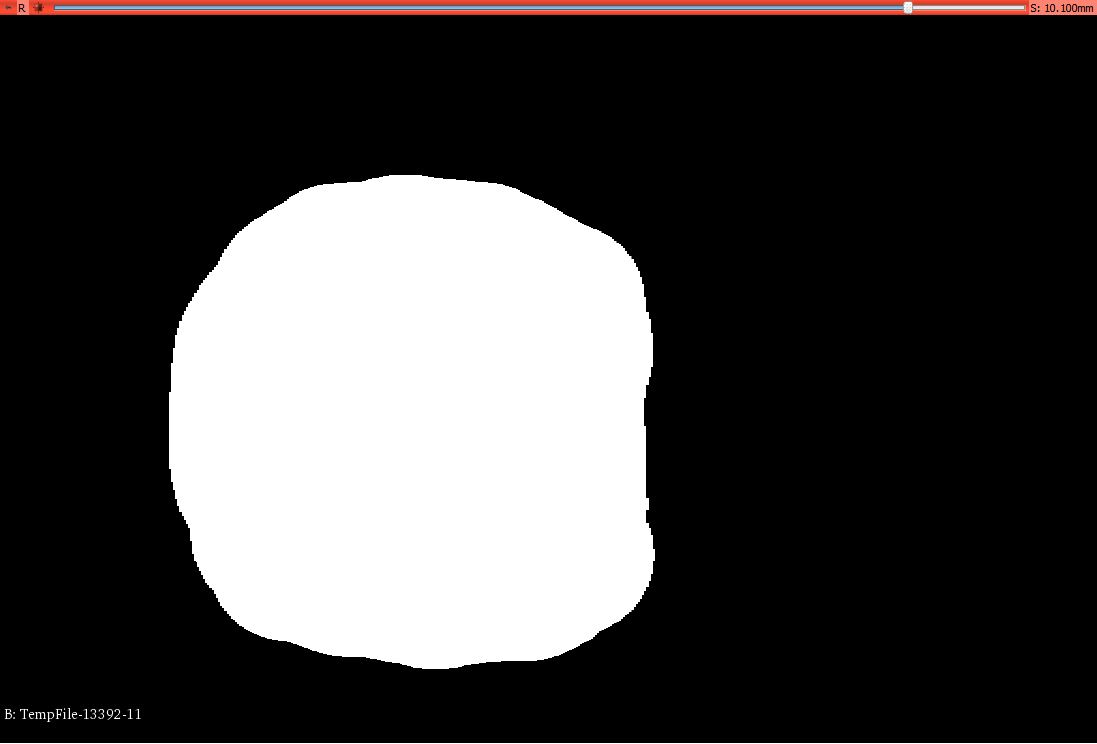

<h2>Part 2</h2>

<h5>Part 2a</h5>

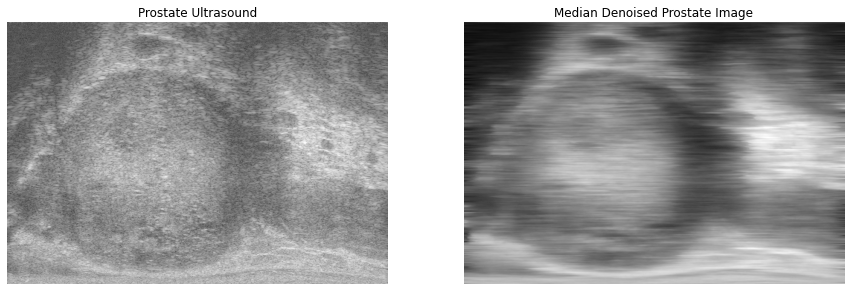

In [139]:
#employ median filter
median_filter = sitk.MedianImageFilter()
median_filter.SetRadius(21)

img_denoised = median_filter.Execute(img_p)


# visualize
plt.figure(figsize=(15,5))
plt.gray()
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(img_p), aspect = 0.035)
plt.axis('off')
plt.title(img_p_name)
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(img_denoised), aspect = 0.035) 
plt.axis('off')
plt.title('Median Denoised Prostate Image')
plt.show()

I explored different kernel sizes above. I started with a kernel size of 5, and incremented it by 5 until I reached 25, and the boundaries of the prostate were no longer clear. I then tried all values between 20-25, and the kernel value of 21 appeared to have the best smoothing quality while still maintaining the important information from the image.

<h5>Part 2b</h5>

Text(0.5, 1.0, 'Denoised Prostate Image')

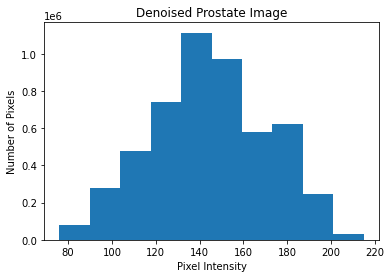

In [140]:
#Get image arrays for both images
img_denoised_array = sitk.GetArrayFromImage(img_denoised)

#Plot pixels in a histogram
plt.hist(img_denoised_array.flatten())
plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels')
plt.title("Denoised Prostate Image")

In [141]:
def histogramEqualization(image, alpha, beta, radius):
    """
    Perform histogram equalization of pixel intensities
    :param image: image object 
    :param alpha: alpha parameter number
    :param beta: beta parameter number
    :param radius: radius parameter number
    :return: image object after histogram equalization is performed
    """
    adapt_filter = sitk.AdaptiveHistogramEqualizationImageFilter()
    adapt_filter.SetAlpha(alpha)
    adapt_filter.SetBeta(beta)
    adapt_filter.SetRadius(radius)
    img_filtered = adapt_filter.Execute(image)
    
    return img_filtered

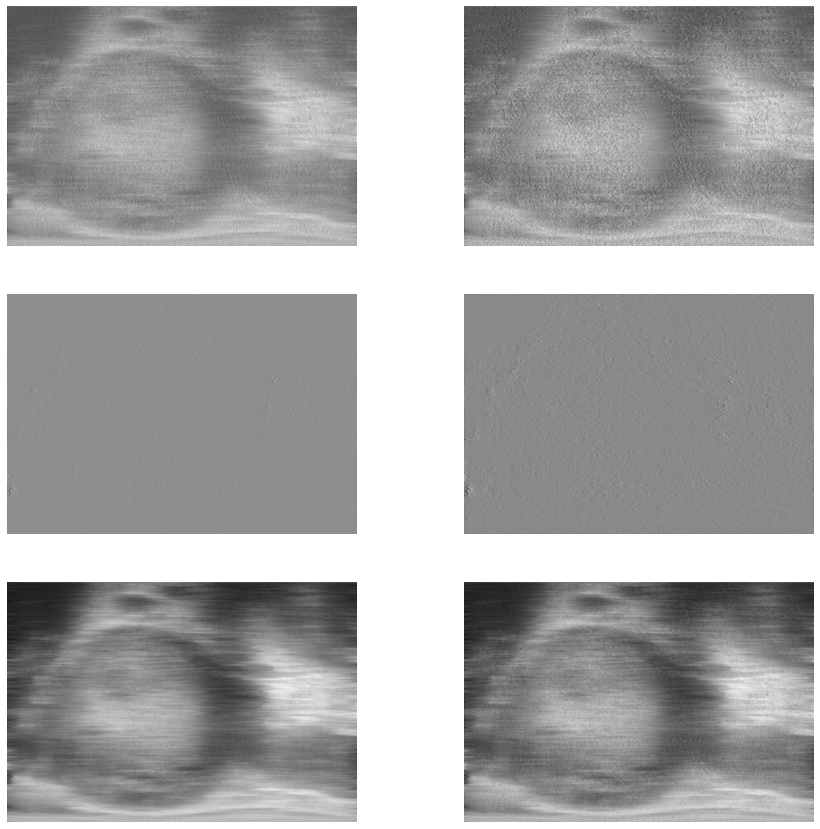

In [142]:
#Apply AdaptiveHistogramEqualizationImageFilter with different sets of parameters for intial viewing

#First params
img_filtered = histogramEqualization(img_denoised,0,1,1)

#Second params
img_filtered1 = histogramEqualization(img_denoised,0,1,2)

#Third params
img_filtered2 = histogramEqualization(img_denoised,1,0,1)

#Fourth params
img_filtered3 = histogramEqualization(img_denoised,1,0,2)

#Fifth params
img_filtered4 = histogramEqualization(img_denoised,0.5,0.5,1)

#Sixth params
img_filtered5 = histogramEqualization(img_denoised,0.5,0.5,2)

plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.imshow(sitk.GetArrayFromImage(img_filtered), aspect = 0.035)
plt.axis('off')
plt.subplot(3,2,2)
plt.imshow(sitk.GetArrayFromImage(img_filtered1), aspect = 0.035) 
plt.axis('off')
plt.subplot(3,2,3)
plt.imshow(sitk.GetArrayFromImage(img_filtered2), aspect = 0.035) 
plt.axis('off')
plt.subplot(3,2,4)
plt.imshow(sitk.GetArrayFromImage(img_filtered3), aspect = 0.035)
plt.axis('off')
plt.subplot(3,2,5)
plt.imshow(sitk.GetArrayFromImage(img_filtered4), aspect = 0.035) 
plt.axis('off')
plt.subplot(3,2,6)
plt.imshow(sitk.GetArrayFromImage(img_filtered5), aspect = 0.035) 
plt.axis('off')
plt.show()

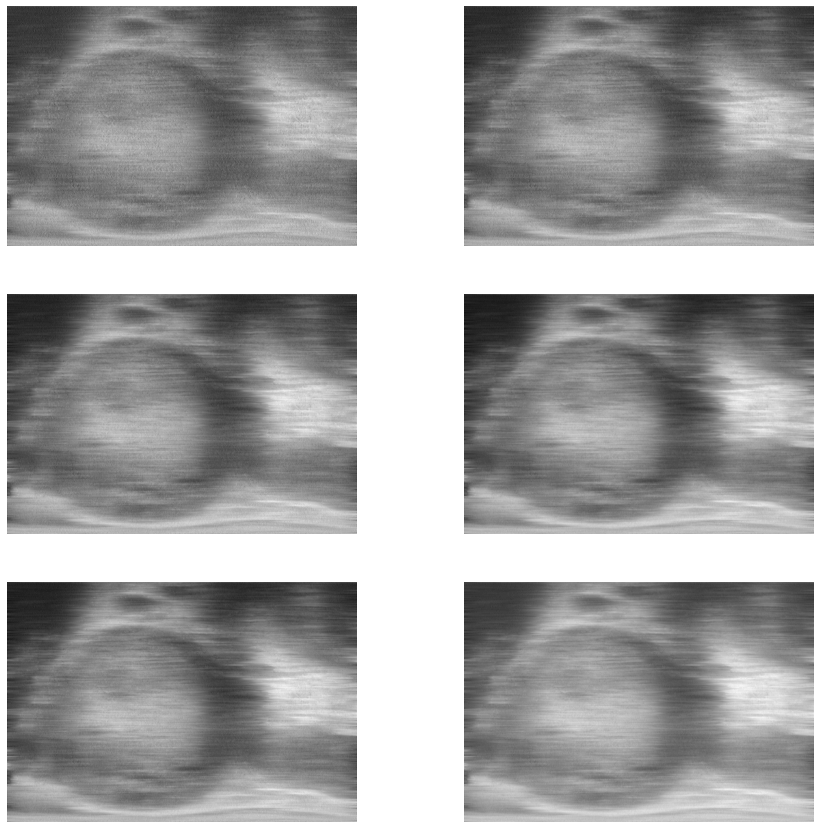

In [143]:
#img_filtered4 followed by img_filtered were the most visually appealing -> now test second round of params close to the chosen values

#First params
img_filtered6 = histogramEqualization(img_denoised,0.1,1,1)

#Second params
img_filtered7 = histogramEqualization(img_denoised,0.2,1,1)

#Third params
img_filtered8 = histogramEqualization(img_denoised,0.3,1,1)

#Fourth params
img_filtered9 = histogramEqualization(img_denoised,0.4,1,1)

#Fifth params
img_filtered10 = histogramEqualization(img_denoised,0.3,1.2,1)

#Sixth params
img_filtered11 = histogramEqualization(img_denoised,0.3,1.5,1)

plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.imshow(sitk.GetArrayFromImage(img_filtered6), aspect = 0.035)
plt.axis('off')
plt.subplot(3,2,2)
plt.imshow(sitk.GetArrayFromImage(img_filtered7), aspect = 0.035) 
plt.axis('off')
plt.subplot(3,2,3)
plt.imshow(sitk.GetArrayFromImage(img_filtered8), aspect = 0.035) 
plt.axis('off')
plt.subplot(3,2,4)
plt.imshow(sitk.GetArrayFromImage(img_filtered9), aspect = 0.035)
plt.axis('off')
plt.subplot(3,2,5)
plt.imshow(sitk.GetArrayFromImage(img_filtered10), aspect = 0.035) 
plt.axis('off')
plt.subplot(3,2,6)
plt.imshow(sitk.GetArrayFromImage(img_filtered11), aspect = 0.035) 
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Filtered Prostate Image')

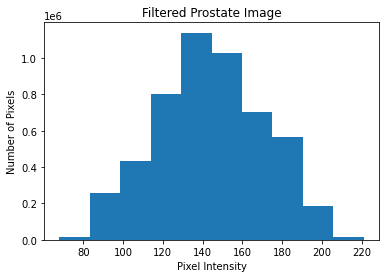

In [144]:
#I chose img_filtered9 as the most visually appealing

#Get image arrays for both images
img_filtered_array = sitk.GetArrayFromImage(img_filtered9)

#Plot pixels in a histogram
plt.hist(img_filtered_array.flatten())
plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels')
plt.title("Filtered Prostate Image")

<h2>Part 3</h2>

<h5>Part 3a</h5>

In [145]:
#View filtered prostate image in 3D Slicer
external_viewer.Execute(img_filtered9)

Range inside prostate gland is approximately: 110 - 195 <br>
Range outside prostate gland is approximately: = 70 - 220

<h5>Part 3b</h5>

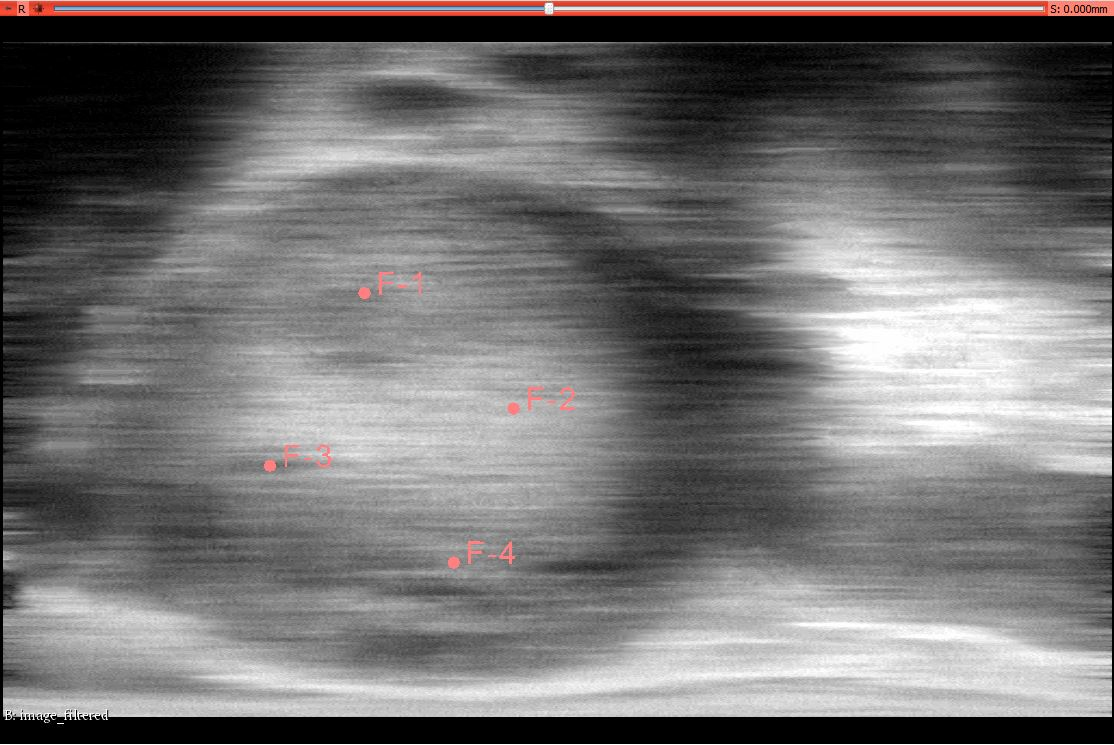


In [146]:
#LPS coordingates of fiducials inside prostate
fid1 = (15.0,10.4,0)
fid2 = (21.2,15.2,0)
fid3 = (11.0,17.6,0)
fid4 = (18.7,21.6,0)

<h5>Part 3c</h5>

In [147]:
def segmentProstate(image,fiducial1,fiducial2,fiducial3,fiducial4,lowerBound,upperBound):
    """
    Segment the prostate from the rest of the image
    :param image: image object
    :param fiducial1: A seed point with coordinates in the L and P axes 
    :param fiducial2: A seed point with coordinates in the L and P axes 
    :param fiducial3: A seed point with coordinates in the L and P axes 
    :param fiducial4: A seed point with coordinates in the L and P axes 
    :param lowerBound: lowest pixel intensity to include in segmentation
    :param upperBound: highest pixel intensity to include in segmentation
    :return: image object with prostate segmented in white
    """
    spacingL = image.GetSpacing()[0]
    spacingP = image.GetSpacing()[1]


    Seed1 = (int(fiducial1[0]/spacingL), int(fiducial1[1]/spacingP))
    Seed2 = (int(fiducial2[0]/spacingL), int(fiducial2[1]/spacingP))
    Seed3 = (int(fiducial3[0]/spacingL), int(fiducial3[1]/spacingP))
    Seed4 = (int(fiducial4[0]/spacingL), int(fiducial4[1]/spacingP))
    
    SeedList = [Seed1,Seed2,Seed3,Seed4]

    segment = sitk.ConnectedThreshold(image, seedList=SeedList, lower=lowerBound, upper=upperBound)
    
    return segment

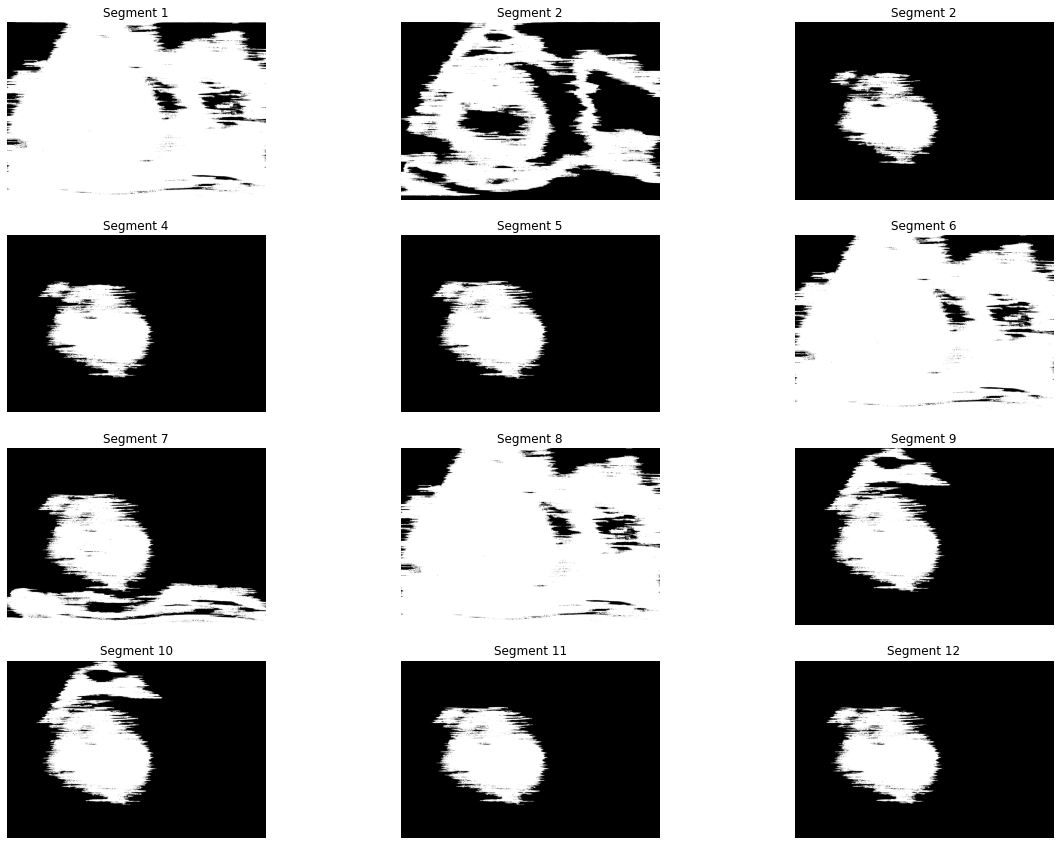

In [152]:
#Segment the prostate gland, testing several different parameter
###Note: I have tested many different lower and upper bounds, ranging from 80-220, but I am displaying 12 sets of parameters here

#First params
segment1 = segmentProstate(img_filtered9,fid1,fid2,fid3,fid4,110,195)

#Second params
segment2 = segmentProstate(img_filtered9,fid1,fid2,fid3,fid4,130,170)

#Third params
segment3 = segmentProstate(img_filtered9,fid1,fid2,fid3,fid4,148,220)

#Fourth params
segment4 = segmentProstate(img_filtered9,fid1,fid2,fid3,fid4,145,200)

#Fifth params
segment5 = segmentProstate(img_filtered9,fid1,fid2,fid3,fid4,143,200)

#New seed points to try
fid1a = (12.4, 12.6)
fid2a = (24.1, 16.3)
fid3a = (23.4, 23.5)
fid4a = (13.0, 21.5)

fid1b = (13.1, 8.7)
fid2b = (17.1, 13.4)
fid3b = (12.6, 20.1)
fid4b = (21.1, 24.6)

fid1c = (12.4, 9.3)
fid2c = (21.6, 10.3)
fid3c = (13.2, 20.7)
fid4c = (23.0, 21.6)

#Sixth params
segment6 = segmentProstate(img_filtered9,fid1a,fid2a,fid3a,fid4a,110,195)

#Seventh params
segment7 = segmentProstate(img_filtered9,fid1a,fid2a,fid3a,fid4a,143,190)

#Eigth params
segment8 = segmentProstate(img_filtered9,fid1b,fid2b,fid3b,fid4b,110,195)

#Ninth params
segment9 = segmentProstate(img_filtered9,fid1b,fid2b,fid3b,fid4b,142,200)

#Tenth params
segment10 = segmentProstate(img_filtered9,fid1c,fid2c,fid3c,fid4c,142,200)

#Eleventh params
segment11 = segmentProstate(img_filtered9,fid1c,fid2c,fid3c,fid4c,143,200)

#Twelth params
segment12 = segmentProstate(img_filtered9,fid1c,fid2c,fid3c,fid4c,144,200)

plt.figure(figsize=(20,15))
plt.subplot(4,3,1)
plt.imshow(sitk.GetArrayFromImage(segment1), aspect = 0.035)
plt.axis('off')
plt.title('Segment 1')
plt.subplot(4,3,2)
plt.imshow(sitk.GetArrayFromImage(segment2), aspect = 0.035) 
plt.axis('off')
plt.title('Segment 2')
plt.subplot(4,3,3)
plt.imshow(sitk.GetArrayFromImage(segment3), aspect = 0.035) 
plt.axis('off')
plt.title('Segment 2')
plt.subplot(4,3,4)
plt.imshow(sitk.GetArrayFromImage(segment4), aspect = 0.035)
plt.axis('off')
plt.title('Segment 4')
plt.subplot(4,3,5)
plt.imshow(sitk.GetArrayFromImage(segment5), aspect = 0.035) 
plt.axis('off')
plt.title('Segment 5')
plt.subplot(4,3,6)
plt.imshow(sitk.GetArrayFromImage(segment6), aspect = 0.035) 
plt.axis('off')
plt.title('Segment 6')
plt.subplot(4,3,7)
plt.imshow(sitk.GetArrayFromImage(segment7), aspect = 0.035)
plt.axis('off')
plt.title('Segment 7')
plt.subplot(4,3,8)
plt.imshow(sitk.GetArrayFromImage(segment8), aspect = 0.035) 
plt.axis('off')
plt.title('Segment 8')
plt.subplot(4,3,9)
plt.imshow(sitk.GetArrayFromImage(segment9), aspect = 0.035) 
plt.axis('off')
plt.title('Segment 9')
plt.subplot(4,3,10)
plt.imshow(sitk.GetArrayFromImage(segment10), aspect = 0.035) 
plt.axis('off')
plt.title('Segment 10')
plt.subplot(4,3,11)
plt.imshow(sitk.GetArrayFromImage(segment11), aspect = 0.035) 
plt.axis('off')
plt.title('Segment 11')
plt.subplot(4,3,12)
plt.imshow(sitk.GetArrayFromImage(segment12), aspect = 0.035) 
plt.axis('off')
plt.title('Segment 12')
plt.show()

<h5>Part 3d</h5>

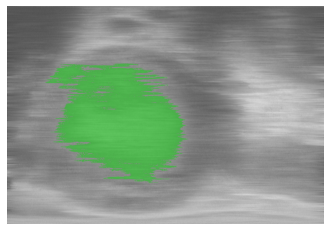

In [151]:
#The best segments appear to be segment5 and segment11

img_overlay = sitk.LabelOverlay(img_filtered9, segment5)

plt.imshow(sitk.GetArrayFromImage(img_overlay), aspect = 0.035)
plt.axis('off')
plt.show()

Although I have restricted my segment to the prostate region, the segment does not cover the whole prostate (like the given segment image does). I played around with various kernel sizes for median filtering, and various parameters for histogram equalization, but I think the pixels within and outside the prostate region are still too similar. More refined pre-processing of the image may help with producing a more exact segment.

<h2>Part 4</h2>

<h5>Part 4a</h5>

In [ ]:
#Calculate area of the prostate from the segmented image
num_pixels = np.count_nonzero(img_s == 255)
A = num_pixels * img_s.GetSpacing()[0] * img_s.GetSpacing()[1]
A_round = round(A,2)

print("The area of the prostate is: {} mm^2.".format(A_round))

<h5>Part 4b</h5>

In [ ]:
#Calculate volume of the prostate
c = 15

V = 4/3*A*c
V_round = round(V,2)

print("The volume of the prostate is: {} mm^3.".format(V_round))

<h5>Part 4c</h5>

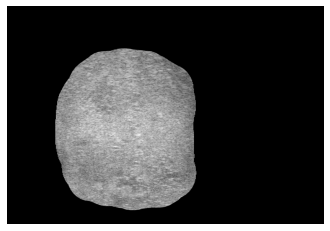

The average pixel intensity in the prostate region is approximately: 147.18.
The standard deviation of the pixel intensity in the prostate region is approximately: 24.09.


In [138]:
#Calculate mean and SD of pixel intensities inside the prostate region

#Change 255 values in segment to 1
img_s = sitk.Clamp(img_s, upperBound=1)

#Create mask
img_masked = img_s * img_p

#Check that mask worked
plt.imshow(sitk.GetArrayFromImage(img_masked), aspect = 0.035)
plt.axis('off')
plt.show()

#Calculate mean intensity of pixels in prostate region by comparing mask to original image
img_pixels = sitk.GetArrayFromImage(img_masked) 
match_pixels = img_pixels[img_pixels == sitk.GetArrayFromImage(img_p)]
pixel_mean = np.round(np.mean(match_pixels),2)
print("The average pixel intensity in the prostate region is approximately: {}.".format(pixel_mean))

#Calculate SD of pixel intensities in prostate region
pixel_sd = np.round(np.std(match_pixels),2)
print("The standard deviation of the pixel intensity in the prostate region is approximately: {}.".format(pixel_sd))